## Занятие 3. Pytorch туториал (продолжение). Семантическая сегментация.

In [1]:
#!g2.mig
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#!g2.mig
import torchvision
from pathlib import Path
from torchvision import transforms
from torch.utils import data as tdata

In [3]:
#!g2.mig
torch.cuda.is_available()

True

### 1. Данные: SUIM (Segmentation of Underwater IMagery)

Главная страница: https://irvlab.cs.umn.edu/resources/suim-dataset

Paperswithcode: https://paperswithcode.com/dataset/suim

Загрузка: https://drive.google.com/drive/folders/10KMK0rNB43V2g30NcA1RYipL535DuZ-h

Путь в Datasphere: `/home/jupyter/mnt/datasets/SUIM_Dataset`

![sample was not loaded](sample.png "Suim sample")

### 1.2 Датасет: data.Dataset

In [4]:
#!g2.mig
from pathlib import Path
SUIM_ROOT = Path(r"/home/jupyter/mnt/datasets/SUIM_Dataset")
assert SUIM_ROOT.exists()

In [4]:
#!g2.mig
from typing import Tuple, List
from PIL import Image
from torchvision import transforms
from tqdm import tqdm


class SuimDataset(tdata.Dataset):
    IMAGES_FOLDER = "images"
    MASKS_FOLDER = "masks"
    
    LABEL_COLORS = (
        ("Background(waterbody)", "000"),
        ("Human divers", "001"),
        ("Aquatic plants and sea-grass", "010"),
        ("Wrecks and ruins", "011"),
        ("Robots (AUVs/ROVs/instruments)", "100"),
        ("Reefs and invertebrates", "101"),
        ("Fish and vertebrates", "110"),
        ("Sea-floor and rocks", "111")
    )
        
    def __init__(self, root: Path, masks_as_color: bool = True, target_size: Tuple[int, int]=None):
        """
        Args:
            root: путь до датасета
            masks_as_color: возвращать ли маски как цветны изображения (для визуализации) или как one-hot номера классов (для обучения)
            target_size: размер, к которому нужно приводить изображения и маски; None означает "возвращать без изменения размера"
        """
        self.root = Path(root)
        self.samples = self._load_dataset(self.root, masks_as_color=masks_as_color)
        self.target_size = target_size
        
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Возвращает пару тензоров (изображение и маску) по индексу сэмпла.
        Тензоры должны быть приведены к размеру target_size, если target_size не None 
        (например, через transforms.functional.resize).
        """
        if not  (0 <= idx < len(self)):
            raise KeyError(f"Invalid index {idx}")
        raise NotImplementedError("1.1")
        return img, mask
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __repr__(self) -> str:
        return f"<SuimDataset({len(self)})|{self.root}>"
    
    @classmethod
    def _load_dataset(cls, root: Path, masks_as_color: bool) -> List[Tuple[torch.Tensor, torch.Tensor]]:
        """
        Читает датасет в память как массив пар тензоров
        """
        if not root.exists():
            raise ValueError(f"Root {root.absolute()} does not exist")
        images_root = root / cls.IMAGES_FOLDER 
        masks_root = root / cls.MASKS_FOLDER
        
        assert images_root.exists(), f"Images path {images_root.absolute()} does not exist"
        assert masks_root.exists(), f"Masks path {masks_root.absolute()} does not exist"
        
        images_paths = list(images_root.glob("*.jpg"))
        masks_paths = []
        for img_path in images_paths:
            mask_path = masks_root / f"{img_path.stem}.bmp"
            assert mask_path.exists(), f"{mask_path.absolute()} does not exist"
            masks_paths.append(mask_path)
        
        samples = []
        to_tensor = transforms.PILToTensor()
        for (img_path, mask_path) in tqdm(zip(images_paths, masks_paths)):
            img = to_tensor(Image.open(img_path)).float() / 255
            mask = to_tensor(Image.open(mask_path))
            if not masks_as_color:
                mask = cls._mask_color_to_label(mask)
            samples.append([img, mask])
        return samples
    
    @classmethod
    def _mask_color_to_label(cls, mask_color: torch.Tensor) -> torch.Tensor:
        """
        Converts mask[3, H, W] of colors (0-0-0, 0-0-255 ... 255-255-255) into mask[1, H]
        """
        assert mask_color.dtype == torch.uint8, mask_color.dtype
        raise NotImplementedError("1.2")



### Задача 1.1.
Реализовать `__getitem__` с учётом target_resize 

### Задача 1.2.
Реализовать `_mask_color_to_label` 

(две ячейки ниже должны исполняться).

110it [00:01, 82.28it/s]

torch.Size([3, 480, 640]) torch.float32 torch.Size([3, 480, 640]) torch.uint8


<SuimDataset(110)|D:\edu\course_cvdl_full\classes\c03\suim_dataset\TEST>

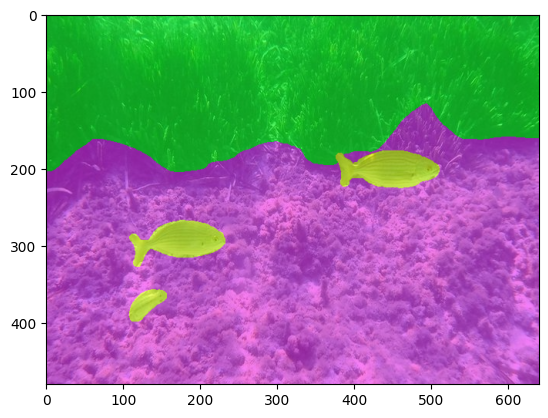

In [5]:
#!g2.mig
# Режим маски-цвета без изменения размера
test_ds = SuimDataset(SUIM_ROOT / "TEST", masks_as_color=True)
to_img = transforms.ToPILImage()
x, y = test_ds[2]
plt.imshow(
    Image.blend(to_img(x), to_img(y), 0.5)
)
print(x.shape, x.dtype, y.shape, y.dtype)
test_ds


110it [00:01, 82.59it/s]


torch.Size([3, 256, 256]) torch.float32 torch.Size([1, 256, 256]) torch.uint8


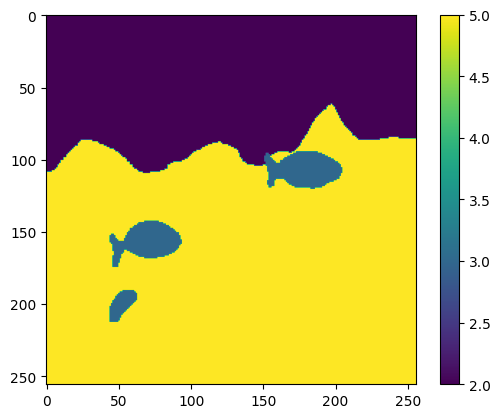

In [6]:
#!g2.mig
# Режим маски-класса с изменением размера
test_ds = SuimDataset(SUIM_ROOT / "TEST", masks_as_color=False, target_size=(256, 256))
to_img = transforms.ToPILImage()
x, y = test_ds[2]
print(x.shape, x.dtype, y.shape, y.dtype)

assert x.shape == (3, 256, 256)
assert y.shape == (1, 256, 256)
plt.imshow(y[0])
plt.colorbar()

In [7]:
#!g2.mig
train_val_ds = SuimDataset(SUIM_ROOT / "train_val", masks_as_color=False, target_size=(256, 256))
train_val_ds

1525it [06:56,  3.66it/s]


<SuimDataset(1525)|D:\edu\course_cvdl_full\classes\c03\suim_dataset\train_val>

### 1.3 Загрузчик: data.DataLoader

In [8]:
#!g2.mig
BATCH_SIZE = 8

In [9]:
#!g2.mig
# Тут можно просто воспользоваться стандартным DataLoader
test_iter = tdata.DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False
)
x, y = next(iter(test_iter))
print(x.shape, y.shape)

torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])


### Задача 1.3
В train_val_ds находятся тренировочные и валидационные данные.

Давайте разделим их с помощью кастомного Sampler-а по правилу: **каждое пятое изображение - валидационное, остальные - тренировочные**

In [10]:
#!g2.mig
import random

class EveryNthFilterSampler(tdata.Sampler):
    def __init__(self, *, dataset_size: int, n: int, pass_every_nth: bool, shuffle: bool):
        self.dataset_size = dataset_size
        self.n = n
        self.pass_every_nth = pass_every_nth
        self.shuffle = shuffle
    
    def _get_index_list(self) -> List[int]:
        """
        Возвращает список индексов датасета, из которого потом сэмплирует DataLoader.
        Если pass_every_nth (пропускать каждый n-ый), 
            то возвращает все индексы, которые нацело делятся на n,
            иначе возвращает все индексы, которые НЕ делятся нацело на n
        """
        raise NotImplementedError("1.3")
    
    def __len__(self):
        return len(self._get_index_list())
    
    def __iter__(self):
        indices = self._get_index_list()
        if self.shuffle:
            random.shuffle(indices)
        return (idx for idx in indices)

    
train_sampler = EveryNthFilterSampler(dataset_size=len(train_val_ds), n=5, pass_every_nth=False, shuffle=True)
val_sampler = EveryNthFilterSampler(dataset_size=len(train_val_ds), n=5, pass_every_nth=True, shuffle=False)

assert len(train_sampler) == 4 * len(val_sampler)
assert set(list(train_sampler)).isdisjoint(set(list(val_sampler)))
assert all([idx % 5 == 0 for idx in val_sampler])
assert all([idx % 5 != 0 for idx in train_sampler])
assert len(list(train_sampler) + list(val_sampler)) == len(train_val_ds)
print("Passed!")

Passed!


In [11]:
#!g2.mig
# Посмотрим индексы train_samplr
print(list(train_sampler)[:20])

[279, 128, 706, 427, 733, 246, 1372, 1417, 1248, 104, 703, 646, 434, 99, 653, 458, 1361, 153, 1441, 1011]


In [12]:
#!g2.mig
# Создаём train loader
train_iter = tdata.DataLoader(
    train_val_ds,
    batch_size=BATCH_SIZE,
    sampler=train_sampler
)
x, y = next(iter(train_iter))
print(x.shape, y.shape, len(train_iter))

torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256]) 153


In [13]:
#!g2.mig
# Создаём val loader
val_iter = tdata.DataLoader(
    train_val_ds,
    batch_size=BATCH_SIZE,
    sampler=val_sampler
)
x, y = next(iter(val_iter))
print(x.shape, y.shape, len(val_iter))

torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256]) 39


### 2. Model: PP-LiteSeg
PP-LiteSeg: A Superior Real-Time Semantic Segmentation Model:

https://arxiv.org/pdf/2204.02681.pdf

https://paperswithcode.com/paper/pp-liteseg-a-superior-real-time-semantic

## Архитектура PP-LiteSeg
![LiteSeg arch was not loaded](liteseg1.png "LiteSeg Arch")

Нужно реализовать:
- Encoder
- Simple Pyramid Pooling (SPP)
- Unified Attention Module + Channel Attention Module
- Decoder

### Количество каналов в разных модулях сети

![LiteSeg arch was not loaded](liteseg2.png "LiteSeg Arch")
![LiteSeg arch was not loaded](liteseg3.png "LiteSeg Arch")

In [14]:
#!g2.mig
# Используем в качестве энкодера ShuffleNet-v2
from torchvision.models import shufflenet_v2_x0_5
import torch


shflnet = shufflenet_v2_x0_5()
z0 = torch.rand((2, 3, 256, 256))
z = z0

for num, (name, layer) in enumerate(shflnet.named_children()):
    print(f"{num}) {name}: {z.shape}\t (x = 1/{z0.size(-1) // z.size(-1)} input)")
    if name == 'fc':
        break
    z = layer(z)



0) conv1: torch.Size([2, 3, 256, 256])	 (x = 1/1 input)
1) maxpool: torch.Size([2, 24, 128, 128])	 (x = 1/2 input)
2) stage2: torch.Size([2, 24, 64, 64])	 (x = 1/4 input)
3) stage3: torch.Size([2, 48, 32, 32])	 (x = 1/8 input)
4) stage4: torch.Size([2, 96, 16, 16])	 (x = 1/16 input)
5) conv5: torch.Size([2, 192, 8, 8])	 (x = 1/32 input)
6) fc: torch.Size([2, 1024, 8, 8])	 (x = 1/32 input)


In [15]:
#!g2.mig
from torchvision.models import shufflenet_v2_x0_5, ShuffleNet_V2_X0_5_Weights

class ShuffleNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.md = shufflenet_v2_x0_5(weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1)
    
    def forward(self, x):
        c1 = self.md.conv1(x) # 1/2
        c2 = self.md.maxpool(c1) # 1/4
        c3 = self.md.stage2(c2)# 1/8
        c4 = self.md.stage3(c3)# 1/16
        c5 = self.md.stage4(c4)# 1/32
        return c3, c4, c5


enc = ShuffleNetEncoder()

x = torch.zeros(4, 3, 256, 256)
y = enc(x)
[(t.shape, f"1/{256//t.shape[-1]}") for t in y]

Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to C:\Users\bzimka/.cache\torch\hub\checkpoints\shufflenetv2_x0.5-f707e7126e.pth
100%|██████████████████████████████████████████████████████████████████████████████| 5.28M/5.28M [00:00<00:00, 178MB/s]


[(torch.Size([4, 48, 32, 32]), '1/8'),
 (torch.Size([4, 96, 16, 16]), '1/16'),
 (torch.Size([4, 192, 8, 8]), '1/32')]

In [23]:
#!g2.mig
from einops import rearrange, reduce
    
    
class ConvBNReLU(nn.Module):
    """Базовый блок сети"""
    def __init__(self, 
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int = 3,
                 padding: int = 1,
                 use_normalization: bool = True,
                 use_activation: bool = True,
                 conv_kwargs: dict = {},
                 bn_kwargs: dict = {}
                 ):

        super().__init__()
        self.seq = nn.Sequential()
        self.seq.add_module("conv1", nn.Conv2d(in_channels,
                                              out_channels,
                                              kernel_size=1,
                                              padding=0,
                                              **conv_kwargs))
        if kernel_size != 1:
            self.seq.add_module("convK", nn.Conv2d(out_channels,
                                              out_channels,
                                              kernel_size=kernel_size,
                                              padding=padding,
                                              groups=out_channels,
                                              **conv_kwargs))
        if use_normalization:
            self.seq.add_module("bn", nn.BatchNorm2d(out_channels, **bn_kwargs))
        if use_activation:
            self.seq.add_module("relu", nn.ReLU())

    def forward(self, x):
        return self.seq(x)
    
    


![LiteSeg arch was not loaded](liteseg4.png "LiteSeg Arch")

In [16]:
#!g2.mig
def upscale(x: torch.Tensor, scale: int = 2) -> torch.Tensor:
    """
    Увеличение в s раз через билинейную интерполяцию
    [B C H W] -> [B C sH sW]
    """
    if scale == 1:
        return x
    return torch.nn.functional.interpolate(x, scale_factor=scale, mode='bilinear')

def downscale(x: torch.Tensor, scale: int = 2) -> torch.Tensor:
    """
    Уменьшение в s раз через MeanPool
    [B C H W] -> [B C H/s W/s] 
    """
    if scale == 1:
        return x
    return reduce(x, 'b c (h s1) (w s2) -> b c h w', 'mean', s1=scale, s2=scale)

In [17]:
#!g2.mig

class SPPBranch(nn.Module):
    def __init__(self, in_channels: int, out_channels:int , scale: int):
        super().__init__()
        self.scale = scale
        self.conv =  ConvBNReLU(in_channels=in_channels, out_channels=out_channels, kernel_size=1, padding=0)
    
    def forward(self, x):
        raise NotImplementedError("2")

class SimplePyramidPooling(nn.Module):
            
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch1 = SPPBranch(in_channels=in_channels, out_channels=out_channels, scale=1)        
        self.branch2 = SPPBranch(in_channels=in_channels, out_channels=out_channels, scale=2)
        self.branch4 = SPPBranch(in_channels=in_channels, out_channels=out_channels, scale=4)

        self.conv_final = ConvBNReLU(in_channels=out_channels, out_channels=out_channels)
    
    def forward(self, x):
        return self.conv_final(
            self.branch1(x) + self.branch2(x) + self.branch4(x)
        )

![LiteSeg arch was not loaded](liteseg5.png "LiteSeg Arch")

In [18]:
#!g2.mig
class UnifiedAttentionModule(nn.Module):
    """
    UAFM как на картинке
    """
    def __init__(self, attn: nn.Module):
        super().__init__()
        self.attn = attn
        
    def forward(self, x, x_up):
        assert x.size(2) == x_up.size(2) * 2, (x.shape, x_up.shape)
        assert x.size(3) == x_up.size(3) * 2, (x.shape, x_up.shape)
        
        x_up = upscale(x_up)
        alpha = self.attn(x, x_up)
        return x * alpha + (1 - alpha) * x_up
    

class UnifiedAttentionModuleWithProjections(UnifiedAttentionModule):
    """
    UAFM с предварительной проекцией в одинаковое количество каналов
    """
    def __init__(self, in_channels: int, in_channels_up: int, out_channels: int, **kwargs):
        super().__init__(**kwargs)
        self.conv = ConvBNReLU(in_channels=in_channels, out_channels=out_channels)
        self.conv_up = ConvBNReLU(in_channels=in_channels_up, out_channels=out_channels)
    
    def forward(self, x, x_up):
        x = self.conv(x)
        x_up = self.conv_up(x_up)
        return super().forward(x, x_up)


In [19]:
#!g2.mig
class SpatialAttentionModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x_low, x_high):
        p_xlow_max = reduce(x_low, 'b c h w -> b 1 h w', reduction='max')
        p_xlow_mean = reduce(x_low, 'b c h w -> b 1 h w', reduction='mean')
        p_xhigh_max = reduce(x_high, 'b c h w -> b 1 h w', reduction='max')
        p_xhigh_mean = reduce(x_high, 'b c h w -> b 1 h w', reduction='mean')

        y = rearrange(
            [p_xlow_max, p_xlow_mean, p_xhigh_max, p_xhigh_mean],
            'N b 1 h w -> b N h w', N=4
        )
        y = self.conv(y)
        return y.sigmoid()

In [20]:
#!g2.mig
       
class ChannelAttentionModule(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=4 * in_channels, out_channels=in_channels, kernel_size=3, padding=1)

    def forward(self, x_low, x_high):
        raise NotImplementedError("4")

In [21]:
#!g2.mig
        
class LiteSeg(nn.Module):
    def __init__(self, 
            encoder: nn.Module, 
            num_classes: int, 
            encoder_channels = [116, 232, 464],
            decoder_channels = [128, 64, 32]
        ):
        super().__init__()

        self.encoder_channels = encoder_channels
        self.decoder_channels = decoder_channels
        
        self.encoder = encoder
        self.c6 = SimplePyramidPooling(in_channels=encoder_channels[-1], out_channels=decoder_channels[0])
        self.c7 = UnifiedAttentionModuleWithProjections(
            in_channels_up=decoder_channels[0],
            in_channels=encoder_channels[-2],
            out_channels=decoder_channels[1],
            attn=ChannelAttentionModule(in_channels=decoder_channels[1]),
        )
        self.c8 = UnifiedAttentionModuleWithProjections(
            in_channels_up=decoder_channels[1],
            in_channels=encoder_channels[-3],
            out_channels=decoder_channels[2],
            attn=ChannelAttentionModule(in_channels=decoder_channels[2]),
        )
        self.up = lambda x: upscale(x)
        self.head = nn.Sequential( 
            nn.Conv2d(in_channels=decoder_channels[2], out_channels=num_classes, kernel_size=1),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        #1/8, 1/16, 1/32
        x_c3, x_c4, x_c5 = self.encoder(x)
        
        assert x_c3.shape[1] == self.encoder_channels[0], (x_c5.shape, self.encoder_channels)
        assert x_c4.shape[1] == self.encoder_channels[1], (x_c4.shape, self.encoder_channels)
        assert x_c5.shape[1] == self.encoder_channels[2], (x_c3.shape, self.encoder_channels)
        
        y_c6 = self.c6(x_c5)
        y_c7 = self.c7(x_c4, y_c6)
        y_c8 = self.c8(x_c3, y_c7)

        y = self.up(y_c8) #1/4
        return self.head(y)
        
    

In [24]:
#!g2.mig
model = LiteSeg(ShuffleNetEncoder(), num_classes=8, encoder_channels=[48, 96, 192])

In [25]:
#!g2.mig
y = model(x)
y.shape, x.shape

(torch.Size([4, 8, 64, 64]), torch.Size([4, 3, 256, 256]))

In [26]:
#!g2.mig
# Заморозим предобученные encoder слои
model.encoder.requires_grad_(False);
print(sum(p.numel() for p in model.parameters()))
sum(p.numel() for p in model.parameters() if p.requires_grad)

1664816


298024

### 3. Метрики, Loss

In [29]:
#!g2.mig
# В качестве простейшей метрики - Accuracy

class Accuracy(nn.Module):
    def forward(self, input_prob: torch.Tensor, target: torch.Tensor):
        input_top = torch.argmax(input_prob, dim=1, keepdims=True)
        tp = (input_top == target).byte().sum()
        total = (target >= 0).byte().sum()
        return tp / total
        
metric = Accuracy()

fake_probs = torch.tensor([[0.1, 0.2, 0.7], [0., 0., 1.], [0.3, 0.3, 0.4], [0.05, 0.05, 0.9]])
fake_gt = torch.tensor([[0], [0], [2], [2]])
assert metric(fake_probs, fake_gt) == 0.5

In [30]:
#!g2.mig
# В качестве лосса - DiceLoss
from einops import reduce, rearrange

class DiceLoss(torch.nn.Module):
    """
    https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    DICE = 2 TP / ( 2TP + FP + FN )
    """
    
    def forward(self, predict, target):
        """
        Для каждого класса:
        Результат: Mean(DICE)
        """
        if predict.size(1) != target.size(1):
            b, num_classes, h, w = predict.shape
            target = torch.nn.functional.one_hot(target.long(), num_classes=num_classes).float()
            target = rearrange(target, 'b 1 h w c -> b c h w')
            
        assert predict.shape == target.shape, (predict.shape, target.shape)
        raise NotImplementedError("5")

crit = DiceLoss()

fake_gt = rearrange(
    [torch.ones(1, 1, 4, 3), torch.zeros(1, 1, 4, 3)],
    'N b 1 h w -> b 1 h (N w)', N=2
)

fake_predict = torch.zeros(1, 2, 4, 6) + 0.5
p = 0.99
fake_predict = rearrange(
    [torch.ones(1, 1, 4, 3) - p, torch.zeros(1, 1, 4, 3) + p],
    'N b 1 h w -> b 1 h (N w)', N=2
)

print(fake_gt)
print(fake_predict)

loss = crit(fake_predict, fake_gt)
loss

tensor([[[[1., 1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0., 0.],
          [1., 1., 1., 0., 0., 0.]]]])
tensor([[[[0.0100, 0.0100, 0.0100, 0.9900, 0.9900, 0.9900],
          [0.0100, 0.0100, 0.0100, 0.9900, 0.9900, 0.9900],
          [0.0100, 0.0100, 0.0100, 0.9900, 0.9900, 0.9900],
          [0.0100, 0.0100, 0.0100, 0.9900, 0.9900, 0.9900]]]])


tensor([0.9900])

### 4. Тренировка

In [31]:
#!g2.mig
from tqdm import tqdm


class Trainer:
    def __init__(self, *, 
                 net: nn.Module, opt: torch.optim.Optimizer,
                 train_loader: tdata.DataLoader, val_loader: tdata.DataLoader, test_loader: tdata.DataLoader, 
                 loss: nn.Module, metric: nn.Module, 
    ):
        self.net = net
        self.opt = opt
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        
        self.loss = loss
        self.metric = metric

        self.device = list(net.parameters())[0].device
        
    def run_epoch(self, loader, log_freq=10):
        is_training = self.net.training
        
        loss_values = []
        metric_values = []
        
        for num, (x, y) in enumerate((iter(loader))):
            x, y = x.to(self.device), y.to(self.device)
            yp = self.net(x)
            if y.size(-1) != yp.size(-1):
                h = yp.size(-1)
                y = transforms.functional.resize(
                    y, size=(h,h), 
                    interpolation=transforms.functional.InterpolationMode.NEAREST, 
                    antialias=False
                )
            
            loss_val = self.loss(yp, y).mean()
            metric_val = self.metric(yp, y).mean()
            
            if is_training:
                self.opt.zero_grad()
                loss_val.backward()
                self.opt.step()
                
            if num % log_freq == 0:
                loss_values.append(loss_val.detach().cpu().item())
                metric_values.append(metric_val.detach().cpu().numpy())
                
        print(f"Stats: Loss={np.mean(loss_values):.2f} Metric={np.mean(metric_values):.2f}")
        return loss_values, metric_values
    
    def __call__(self, num_epochs):
        stats = {
            "train": [],
            "val": [],
            "test": []
        }
        for e in tqdm(range(num_epochs)):
            print(f"== Epoch {e} ==")
            print(f"Training:")    
            self.net.train()
            epoch_stats = self.run_epoch(self.train_loader)
            stats['train'].append(epoch_stats)
            
            print(f"Validating:")  
            self.net.eval()
            epoch_stats = self.run_epoch(self.val_loader, log_freq=1)
            stats['val'].append(epoch_stats)
        
        self.net.eval()
        print(f"Testing:")  
        epoch_stats = self.run_epoch(self.test_loader, log_freq=1)
        stats['test'].append(epoch_stats)
        return stats
            

In [32]:
#!g2.mig
model = model.to('cuda:0')
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

trainer = Trainer(
    net=model, opt=opt,
    train_loader=train_iter, val_loader=val_iter, test_loader=test_iter, 
    loss=crit, metric=metric
)

stats = trainer(num_epochs=20)

100%|██████████| 20/20 [02:04<00:00,  6.25s/it]


== Epoch 0 ==
Training:
Stats: Loss=0.88 Metric=0.55
Validating:
Stats: Loss=0.84 Metric=0.67
== Epoch 1 ==
Training:
Stats: Loss=0.82 Metric=0.66
Validating:
Stats: Loss=0.80 Metric=0.70
== Epoch 2 ==
Training:
Stats: Loss=0.80 Metric=0.70
Validating:
Stats: Loss=0.79 Metric=0.72
== Epoch 3 ==
Training:
Stats: Loss=0.79 Metric=0.70
Validating:
Stats: Loss=0.77 Metric=0.74
== Epoch 4 ==
Training:
Stats: Loss=0.77 Metric=0.75
Validating:
Stats: Loss=0.77 Metric=0.74
== Epoch 5 ==
Training:
Stats: Loss=0.77 Metric=0.73
Validating:
Stats: Loss=0.76 Metric=0.75
== Epoch 6 ==
Training:
Stats: Loss=0.76 Metric=0.75
Validating:
Stats: Loss=0.76 Metric=0.75
== Epoch 7 ==
Training:
Stats: Loss=0.76 Metric=0.77
Validating:
Stats: Loss=0.76 Metric=0.75
== Epoch 8 ==
Training:
Stats: Loss=0.74 Metric=0.77
Validating:
Stats: Loss=0.75 Metric=0.75
== Epoch 9 ==
Training:
Stats: Loss=0.74 Metric=0.78
Validating:
Stats: Loss=0.75 Metric=0.75
== Epoch 10 ==
Training:
Stats: Loss=0.75 Metric=0.77
Valida

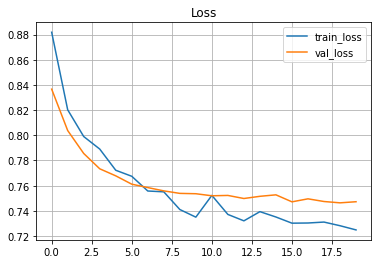

In [33]:
#!g2.mig
plt.plot(np.array(stats['train'])[:, 0].mean(axis=-1), label='train_loss')
plt.plot(np.array(stats['val'])[:, 0].mean(axis=-1), label='val_loss')
plt.grid()
plt.title("Loss")
plt.legend()

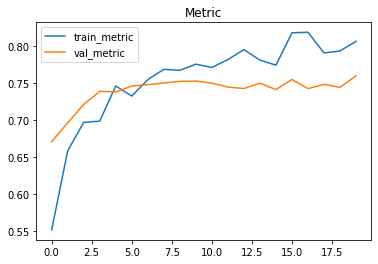

In [34]:
#!g2.mig
plt.plot(np.array(stats['train'])[:, 1].mean(axis=-1), label='train_metric')
plt.plot(np.array(stats['val'])[:, 1].mean(axis=-1), label='val_metric')
plt.title("Metric")
plt.legend()

### Результаты

In [35]:
#!g2.mig
it = iter(test_iter)

In [36]:
#!g2.mig
x, y = next(it)
_id = 2

In [37]:
#!g2.mig
model = model.cpu()
with torch.no_grad():
    yp = model(x)
    ypc = torch.argmax(yp, dim=1, keepdims=True)

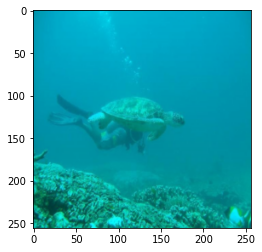

In [38]:
#!g2.mig
plt.imshow(
    to_img(x[_id])
)

torch.Size([8, 1, 256, 256])


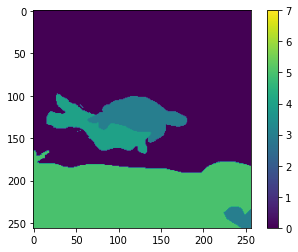

In [39]:
#!g2.mig
print(y.shape)
plt.imshow(y[_id, 0].detach(), vmin=0, vmax=7)
plt.colorbar()

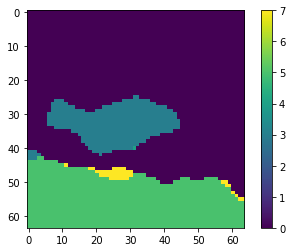

In [40]:
#!g2.mig
plt.imshow(ypc[_id, 0], vmin=0, vmax=7)
plt.colorbar()